# Random Forest! :D

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

import random

random.seed(2)

In [2]:
# GLOBAL VARIABLES
train_split = .8
show_plot = True
num_pred_jokes = 10 # number of jokes you want to predict for a user

# using a random person for demo purposes. can be changed
sample_user = {'major':'Statistics', 'age':21, 'birth_country':"United States", 'gender':"Female", 'id':5}

In [36]:
def lsa_fn(X_tfidf, dim_reduce = 20, print_var=False):
    from sklearn.decomposition import TruncatedSVD 
    from sklearn.preprocessing import Normalizer
    """
    INPUT:
    
    dim_reduce: the number of columns you expect for the results
    X_tfidf: ti-idf matrix 
    
    OUTPUT:
    matrix with reduced dim (should be number_of_jokes x dim_reduce) 
    """
    
    lsa = TruncatedSVD(dim_reduce, algorithm = 'arpack')

    # X_tfidf : 153 x 788 tf-idf matrix
    dtm_lsa = lsa.fit_transform(X_tfidf)

    #reduced matrix (combine this matrix w/ other features)
    dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
    
    if print_var:
        print(str(lsa.explained_variance_.cumsum()[-1] * 100) + "%")
    
    return(dtm_lsa)

In [4]:
def preprocess_feature_df(tfidf, add_df):
    tfidf_df = pd.DataFrame(tfidf)
    tfidf_columns = ["tfidf" + str(i) for i in range((tfidf_df.shape[1]))]
    tfidf_df.columns = tfidf_columns
    feat = pd.concat([add_df, tfidf_df], axis=1)
    feat.rename(columns = {'id':'joke_id'}, inplace = True)
    
    return feat

In [5]:
def remove_low_variance_users(df):
    user_var = {}
    for rater in df.joke_rater_id.unique():
        entries = df[(df['joke_rater_id']==rater)]
        ratings = entries.rating
        var = np.nanvar(ratings)
        if np.isnan(var) == False:
            user_var[rater] = var
            #print(str(rater) + ": " + str(np.nanvar(ratings)))

    bad_keys = dict((k, v) for k, v in user_var.items() if v < 0.4).keys()

    df = df[~df['joke_rater_id'].isin(bad_keys)].reset_index(drop=True) # remove low variance users
    # df = df.loc[0:13398] # remove single entry NaN users -- will cause an issue if the database changes
    
    return df

In [6]:
def impute_NA(df):
    which_drop = df[df.isnull().sum(axis=1) > 2].index
    new_df = df.drop(which_drop)

    modes = new_df.mode()
    new_df.birth_country = new_df.birth_country.fillna("United States")
    new_df.preferred_joke_type = new_df.preferred_joke_type.fillna("Puns")
    new_df.preferred_joke_genre2 = new_df.preferred_joke_genre.fillna("Programming")
    new_df = new_df.drop(new_df[new_df.joke_type.isnull() == True].index)
    new_df.subject = new_df.subject.fillna('0')
    
    return new_df

In [7]:
def change_category_to_dummy(df):
    
    # ignoes all numeric entries
    ignore_col = [i for i in range((df.shape[1])) if (df.iloc[:,i].dtype == np.int64) or (df.iloc[:,i].dtype == np.float64)]
    ignore_col.extend([1, 14, 15]) # ignores id, subject, and text -- assume these are still the column #'s
    ignore_col = sorted(ignore_col)
    
    #new_df.iloc[:,string_col] = pd.get_dummies(new_df.iloc[:,string_col])
    string_col = []
    for i in range((df.shape[1])):
        if i not in ignore_col:
            string_col.append(i)
    # same thing as
    #string_col = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    
    df = pd.concat([df.iloc[:,ignore_col], pd.get_dummies(df.iloc[:,string_col])], axis=1)
    
    return df

In [15]:
def lasso_selection(df2, features):

    lasso = Lasso(alpha=.001, random_state=2).fit(df2[features], df2.rating)
    model = SelectFromModel(lasso, prefit=True)

    lasso_X = model.transform(df2[features])

    new_features = ["rating", "joke_rater_id"] # need these headers
    
    for i, feature in zip(model.get_support(), features): # get headers, since they get lost after lasso
        if i:
            new_features.append(feature)

    df3 = pd.concat([df2.rating.reset_index(drop=True), df2.joke_rater_id.reset_index(drop=True), pd.DataFrame(lasso_X)], axis=1)
    df3.columns = new_features
    
    return df3

In [9]:
def mse(predicted, real):
    real = np.array(real)
    predicted = np.array(predicted)
    temp =  (real - predicted) * (real - predicted)
    n = len(real)
    mse = 1.0 / n * sum(temp)
    return mse

In [17]:
def plot_pred_vs_actual(y_pred, y_test):
    ax = sns.regplot(x=y_test, y=y_pred.astype('float'), scatter_kws={'alpha':0.1})
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted Rating vs. Actual Rating")
    plt.show()

In [20]:
# convert data into one-hot

# assume data is a dict user_dict
def convert_sample_onehot(user_dict, df, features):
    '''
    Works with new user or existing user.
    Input: rater_id = user_dict (age, gender, birth_country, major, id)
           df = combined, cleaned dataframe (df3)
           
    Converts user data into variables inside the dataframe (i.e. df3) so you can pass into the random forest.
    '''
    from itertools import compress
    pd.options.mode.chained_assignment = None
    
    if user_dict['id'] in df.joke_rater_id.unique(): # is user already exists in database
        return df[df.joke_rater_id == user_dict['id']]        
    
    entry = df[df.joke_rater_id == 476] # chose 476 randomly because they rated all 153 jokes
    numRow = entry.shape[0]
    
    if user_dict['gender'] == "Male": # gender
        entry.gender_Female = np.repeat(a=0, repeats=numRow)
    
    entry.age = np.repeat(user_dict['age'], numRow) # age
    entry.joke_rater_id = np.repeat(user_dict['id'], numRow)
    
    ## COUNTRY
    user_country = "birth_country_" + user_dict['birth_country'] # user's country
    avail_countries = list(compress(features, [item.startswith('birth') for item in features])) # country dummies
    country_cols = [i for i, x in enumerate(avail_countries) if x]
    for col in country_cols:
        entry.loc[:, col] = np.repeat(0, numRow) # set all countries to 0 for blank slate
    if user_country in avail_countries:
        entry.loc[:,user_country] = np.repeat(1, numRow) # if user country present, set to 1
           
    ## MAJOR
    user_major = "major_" + user_dict['major'] # user's major
    avail_majors = list(compress(features, [item.startswith('major') for item in features])) # major dummies
    major_cols = [i for i, x in enumerate(avail_majors) if x]
    for col in major_cols:
        entry.loc[:, col] = np.repeat(0, numRow) # set all countries to 0 for blank slate  
        
    if user_major in avail_majors:
        entry.loc[:,user_major] = np.repeat(1, numRow)
        
    return entry

In [34]:
def get_topk_jokes(user_df, rf, joke_df, joke_ids, features, k=10, print_output=True):
    '''
    Returns top k jokes for user (default=10).
    user_df is output from convert_sample_onehot.
    Assumes random forest rf is already trained.
    '''
    preds = rf.predict(user_df[features])
    
    df = pd.DataFrame(joke_ids)
    df['pred'] = preds
    
    topk_id = list(df.sort_values('pred', ascending=False).head(k)['joke_id'])
    
    if print_output:
        joke_details = joke_df[joke_df.joke_id.isin(topk_id)].iloc[:,0:5]
        print(pd.merge(joke_details, df, on='joke_id', how='inner'))
        
    return df

In [19]:
def main():
    
    # 3 dfs from csvs
    rater_df = pd.read_csv("JokeRater.csv")
    rating_df = pd.read_csv("JokeRating.csv")
    joke_df = pd.read_csv("Joke.csv")
    
    ## PRE-PROCESSING DATAAAAAA
    
    # change column names for merging purposes
    rater_df.rename(columns = {'id':'joke_rater_id'}, inplace = True)
    joke_df.rename(columns = {'id':'joke_id'}, inplace = True)
    joke_df['joke_id'] = joke_df['joke_id'].astype(float)
    rater_df = rater_df.drop('joke_submitter_id', axis=1)
    joke_df = joke_df.drop('joke_submitter_id', axis=1)
    joke_df = joke_df.drop('joke_source', axis=1)
    
    # add tf-idf features
    feature_df = pd.read_csv("feature_tfidf.csv")
    add_features = feature_df.iloc[:,1:5] # misc. features like avg length, num words

    X_tfidf = feature_df.iloc[:,6:]
    
    # use LSA to reduce down number of tfidf columns
    reduced_tfidf = lsa_fn(X_tfidf, 100) # 79.3% variance explained
    
    feat = preprocess_feature_df(add_df=add_features, tfidf=reduced_tfidf)

    joke_df = pd.merge(joke_df, feat, on='joke_id', how='outer') # combine new features to joke dataframe
    
    # combine joke raters with their ratings
    df = pd.merge(rating_df, rater_df, on="joke_rater_id", how="outer")
    df = df.drop('id', axis=1)
    
    # deal with low variance users
    df = remove_low_variance_users(df)
    
    # finally, add jokes in
    df = pd.merge(df, joke_df, on='joke_id', how='outer')
    
    # get rid of high NaN entries, and replace categories with modes
    df = impute_NA(df)
    
    # convert categorical variables into dummies (one-hot)
    df2 = change_category_to_dummy(df)
    
    disclude_col = [0, 1, 2, 4, 5] # id's, subject, and text -- might want to double check if db changes
    cols = [i for i in range(df2.shape[1]) if i not in disclude_col] # excluding text, subject, and ID's
    features = df2.columns[cols]
    
    joke_ids = df2[df2.joke_rater_id == 476].joke_id # used later when querying new person
    
    # lasso feature selection
    df3 = lasso_selection(df2, features)
    
    ## RANDOM FORESTTTT
    
    # train test split
    train_size = round(len(rater_df) * train_split) # 80/20 train/test split!

    unique_rater = df3.joke_rater_id.unique() # all unique users

    train_idx = np.random.choice(unique_rater, train_size) # get randomly train_size number of users to put into train
    test_idx = [i for i in unique_rater if i not in train_idx] # remaining users go to test

    train_df = df3.loc[df3['joke_rater_id'].isin(train_idx)]
    test_df = df3.loc[df3['joke_rater_id'].isin(test_idx)]
    
    # time to run random forest regressor
    y = train_df.rating
    Y_list = list(y.values)
    new_cols = range(2, df3.shape[1]) # ignore rating and id
    features = train_df.columns[new_cols]

    rf = RandomForestRegressor(n_estimators=50, max_features='sqrt', random_state=42, max_depth=10) # tuneable parameters
    rf.fit(train_df[features], y) # fitting random forest on train data

    # testing
    y_test = test_df.rating
    y_pred = rf.predict(test_df[features]).astype('float')
    print("Test MSE is: " + str(mse(y_test, y_pred)))
    
    # see distribution of predicted joke score vs. actual joke value
    if show_plot:
        plot_pred_vs_actual(y_pred, y_test)
        
    # see what factors are most important
    s = pd.DataFrame((rf.feature_importances_))

    s = s.transpose()
    s.columns = features
    s = s.transpose()

    print("15 most important features: ")
    print(s.sort_values(by=0, ascending=False).head(15))
    
    ## QUERYING JOKE PREDICTIONS FOR NEW USER
    # Need: age, gender, birth_country, major, joke_rater_id
    
    # using a sample user for now. when real time, just use these functions and input data into dictionary
    sample_df = convert_sample_onehot(sample_user, df3, features)
    preds = get_topk_jokes(sample_df, rf, features=features, joke_df=joke_df, joke_ids=joke_ids, k=num_pred_jokes)

79.3245471006%


C:\Users\Cindy\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice.


Test MSE is: 1.72057987672


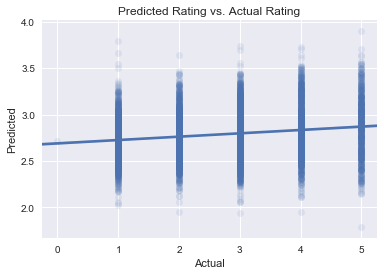

15 most important features: 
                                       0
age                             0.042478
preferred_joke_type_Fun fact    0.036945
birth_country_China             0.033292
major_Physics                   0.033158
favorite_music_genre_Classical  0.023360
major_Statistics                0.022263
preferred_joke_type_Dialogue    0.019424
preferred_joke_genre2_Politics  0.018695
favorite_music_genre_Hip-Hop    0.018591
preferred_joke_genre_Math       0.015811
length                          0.015718
favorite_movie_genre_Thriller   0.015635
tfidf22                         0.014955
favorite_movie_genre_Superhero  0.014877
gender_Female                   0.014702
  joke_id     category   joke_type                      subject  \
0     514  Programming    Question                         Loop   
1     515          Dad  Punch line                     Megabyte   
2     519  Programming  Punch-line  Adding features to programs   
3     520     Children         Pun             

In [35]:
#main()

In [ ]:
if __name__ == '__main__':
    main()